In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from tqdm.auto import tqdm
from joblib import Parallel, delayed
import umap
import pandas as pd

In [2]:
import avgn

In [3]:
from avgn.utils.hparams import HParams
from avgn.dataset import DataSet
from avgn.utils.paths import DATA_DIR, most_recent_subdirectory, ensure_dir
from avgn.signalprocessing.create_spectrogram_dataset import prepare_wav, create_label_df, get_row_audio

In [4]:
DATASET_ID = "git_repos_call"

In [5]:
DT_ID = '2022-03-12_17-46-00'

### Create Dataset

In [6]:
# create a set of hyperparameters for processing this dataset.  
hparams = HParams(
    num_mel_bins = 64,
    mel_lower_edge_hertz=400,
    mel_upper_edge_hertz=8000,
    butter_lowcut = 400,
    butter_highcut = 8000,
    ref_level_db = 20,
    min_level_db = -25,
    mask_spec = False,
    win_length_ms = 5,
    hop_length_ms = 1,
    nex=-1,
    n_jobs=-1,
    verbosity = 1,
)


In [7]:
# create a dataset object, which
dataset = DataSet(DATASET_ID, hparams = hparams)

loading json:   0%|          | 0/152 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:    3.8s
[Parallel(n_jobs=-1)]: Done 152 out of 152 | elapsed:    3.9s finished


getting unique individuals:   0%|          | 0/152 [00:00<?, ?it/s]

In [8]:
import json

In [9]:
# to make sure everything loaded correctly, lets look at a sample JSON
dataset.sample_json

OrderedDict([('filename', 'BWY MGGY Call Combo 1 290719 PM'),
             ('samplerate_hz', 44100),
             ('sex', 'F'),
             ('group', 'BWYa'),
             ('location', 'CRAWLEY'),
             ('wav_loc',
              'C:/Users/slwal/anaconda3/envs/PY36/avgn_paper-2/data/raw/magpie/individuals/BWYa_F_MGGY/BWY MGGY Call Combo 1 290719 PM.WAV'),
             ('length_s', 2.1197732426303855),
             ('species', 'Gymnorhina tibicen dorsalis'),
             ('common_name', 'Western Australian magpie'),
             ('indvs',
              OrderedDict([('MGGY',
                            OrderedDict([('call',
                                          OrderedDict([('ID', [0.0, 1.0]),
                                                       ('labels',
                                                        ['DSSHDS', 'SHSHLH']),
                                                       ('start_times',
                                                        [0.753604333,
  

In [10]:
# how many wavs are in the dataset?
len(dataset.data_files)

152

In [11]:
import librosa

### Create a a pandas dataframe from the dataset
- We use joblib to parallelize the code, but all we're doing is grabbing the call start and stop times from the JSONs (as well as some other info)

In [12]:
from joblib import Parallel, delayed
n_jobs = -1; verbosity = 10

In [13]:
with Parallel(n_jobs=n_jobs, verbose=verbosity) as parallel:
    call_dfs = parallel(
        delayed(create_label_df)(
            dataset.data_files[key].data,
            hparams=dataset.hparams,
            labels_to_retain=[
                'ID', 'labels', 'start_times', 'end_times', 'call_unique_num', 'call_pos_combi', 'combi_label', 
                'combi_unique_num', 'combi_start', 'combi_end'
            ],
            unit="call",
            dict_features_to_retain = ['filename', 'group', 'location','sex', 'wav_loc'],
            key = key,
        )
        for key in tqdm(dataset.data_files.keys())
    )
call_df = pd.concat(call_dfs)
len(call_df)

  0%|          | 0/152 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    0.4s
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.4s
[Parallel(n_jobs=-1)]: Done  17 tasks      | elapsed:    0.4s
[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:    0.4s
[Parallel(n_jobs=-1)]: Batch computation too fast (0.1842s.) Setting batch_size=2.
[Parallel(n_jobs=-1)]: Done  37 tasks      | elapsed:    0.5s
[Parallel(n_jobs=-1)]: Done  48 tasks      | elapsed:    0.5s
[Parallel(n_jobs=-1)]: Done  62 tasks      | elapsed:    0.5s
[Parallel(n_jobs=-1)]: Batch computation too fast (0.0728s.) Setting batch_size=4.
[Parallel(n_jobs=-1)]: Done  88 tasks      | elapsed:    0.6s
[Parallel(n_jobs=-1)]: Done 113 tasks      | elapsed:    0.7s
[Parallel(n_jobs=-1)]: Done 128 tasks      | elapsed:    0.7s
[Parallel(n_jobs=-1)]: Done 145 out of 152 | elapsed:    0.7s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done 152 out of 152 | elapsed:   

697

In [14]:
call_df[:3]

,start_time,end_time,ID,labels,start_times,end_times,call_unique_num,call_pos_combi,combi_label,combi_unique_num,combi_start,combi_end,indv,indvi,filename,group,location,sex,wav_loc,key
0,0.753604,0.921160,0.0,DSSHDS,0.753604,0.921160,0.0,0.0,DSSHDS SHSHLH,0.0,0.753604,1.367130,MGGY,0,BWY MGGY Call Combo 1 290719 PM,BWYa,CRAWLEY,F,C:/Users/slwal/anaconda3/envs/PY36/avgn_paper-...,BWY MGGY Call Combo 1 290719 PM
1,0.932017,1.367130,1.0,SHSHLH,0.932017,1.367130,1.0,1.0,DSSHDS SHSHLH,0.0,0.753604,1.367130,MGGY,0,BWY MGGY Call Combo 1 290719 PM,BWYa,CRAWLEY,F,C:/Users/slwal/anaconda3/envs/PY36/avgn_paper-...,BWY MGGY Call Combo 1 290719 PM
0,1.218085,1.308841,2.0,DS,1.218085,1.308841,2.0,0.0,DS USC,1.0,1.218085,1.984961,MGGY,0,BWY MGGY Call Combo 1 300719 AM,BWYa,CRAWLEY,F,C:/Users/slwal/anaconda3/envs/PY36/avgn_paper-...,BWY MGGY Call Combo 1 300719 AM


In [15]:
##convert to integers
call_df["ID"] = call_df["ID"].astype(int)
call_df["call_unique_num"] = call_df["call_unique_num"].astype(int)
call_df["combi_unique_num"] = call_df["combi_unique_num"].astype(int)
call_df["call_pos_combi"] = call_df["call_pos_combi"].astype(int)

In [16]:
len(call_df)

697

In [17]:
call_df.sort_values(by=['ID'], inplace=True)

### For each call, grab the corresponding audio
- Here we're looking through the wav files corresponding to the syllable, and grabbing the audio starting at `start_time` and ending at `end_time`

In [18]:
with Parallel(n_jobs=n_jobs, verbose=verbosity) as parallel:
    call_dfs = parallel(
        delayed(get_row_audio)(
            call_df[call_df.key == key], 
            dataset.data_files[key].data['wav_loc'], 
            dataset.hparams
        )
        for key in tqdm(call_df.key.unique())
    )
call_df = pd.concat(call_dfs)
len(call_df)

  0%|          | 0/152 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Batch computation too fast (0.0299s.) Setting batch_size=2.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Batch computation too fast (0.0982s.) Setting batch_size=4.
[Parallel(n_jobs=-1)]: Done  28 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done  50 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Batch computation too fast (0.1460s.) Setting batch_size=8.
[Parallel(n_jobs=-1)]: Done  76 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done 105 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-1)]: Done 129 out of 152 | elapsed:    0.4s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done 145 out of 152 | elapsed:    0.5s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done 152 out of 152 | elapsed:    0.6s finished


697

In [19]:
call_df[:3]

,start_time,end_time,ID,labels,start_times,end_times,call_unique_num,call_pos_combi,combi_label,combi_unique_num,...,indv,indvi,filename,group,location,sex,wav_loc,key,audio,rate
0,0.753604,0.921160,0,DSSHDS,0.753604,0.921160,0,0,DSSHDS SHSHLH,0,...,MGGY,0,BWY MGGY Call Combo 1 290719 PM,BWYa,CRAWLEY,F,C:/Users/slwal/anaconda3/envs/PY36/avgn_paper-...,BWY MGGY Call Combo 1 290719 PM,"[0.00046081832, 0.0005334763, 0.0005827676, 0....",44100
1,0.932017,1.367130,1,SHSHLH,0.932017,1.367130,1,1,DSSHDS SHSHLH,0,...,MGGY,0,BWY MGGY Call Combo 1 290719 PM,BWYa,CRAWLEY,F,C:/Users/slwal/anaconda3/envs/PY36/avgn_paper-...,BWY MGGY Call Combo 1 290719 PM,"[0.0067542433, 0.0060326844, 0.0050855842, 0.0...",44100
0,1.218085,1.308841,2,DS,1.218085,1.308841,2,0,DS USC,1,...,MGGY,0,BWY MGGY Call Combo 1 300719 AM,BWYa,CRAWLEY,F,C:/Users/slwal/anaconda3/envs/PY36/avgn_paper-...,BWY MGGY Call Combo 1 300719 AM,"[-0.0006891803, -0.00022784281, 0.0003211794, ...",44100


In [20]:
calls = call_df.audio.values

  0%|          | 0/50 [00:00<?, ?it/s]

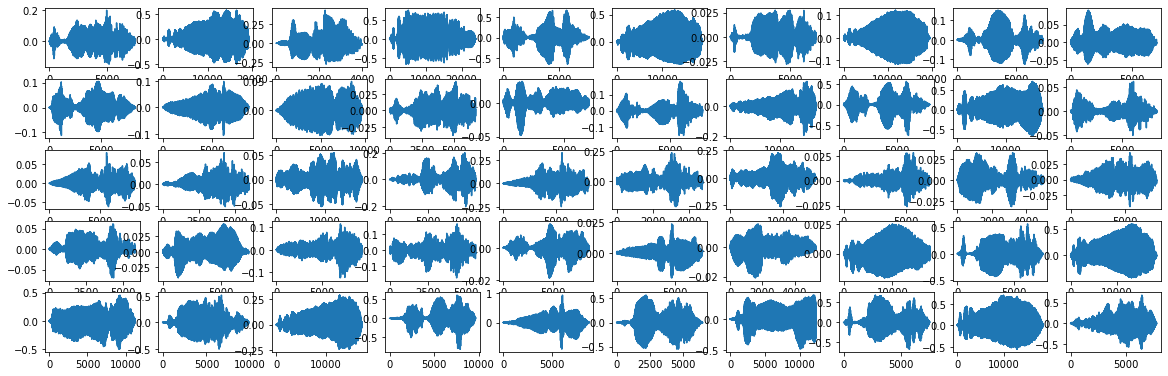

In [21]:
nrows = 5
ncols = 10
zoom = 2
fig, axs = plt.subplots(ncols=ncols, nrows = nrows,figsize = (ncols*zoom, nrows+zoom/1.5))
for i, syll in tqdm(enumerate(calls), total = nrows*ncols):
    ax = axs.flatten()[i]
    ax.plot(syll)
    if i == nrows*ncols -1:
        break

In [22]:
audio_lens = np.array([len(i) for i in call_df['audio']])

(array([ 5.,  8.,  5., 10., 10., 10., 42., 59., 39., 29., 39., 24., 24.,
        33., 19., 19., 21., 14., 22., 15.,  9.,  7.,  9.,  9., 10., 12.,
        18., 15., 16., 10., 10., 13.,  9.,  7., 11.,  8.,  4.,  7.,  2.,
         2.,  8., 11.,  7.,  9., 15.,  3.,  2.,  3.,  2.,  2.]),
 array([ 1922.  ,  2413.58,  2905.16,  3396.74,  3888.32,  4379.9 ,
         4871.48,  5363.06,  5854.64,  6346.22,  6837.8 ,  7329.38,
         7820.96,  8312.54,  8804.12,  9295.7 ,  9787.28, 10278.86,
        10770.44, 11262.02, 11753.6 , 12245.18, 12736.76, 13228.34,
        13719.92, 14211.5 , 14703.08, 15194.66, 15686.24, 16177.82,
        16669.4 , 17160.98, 17652.56, 18144.14, 18635.72, 19127.3 ,
        19618.88, 20110.46, 20602.04, 21093.62, 21585.2 , 22076.78,
        22568.36, 23059.94, 23551.52, 24043.1 , 24534.68, 25026.26,
        25517.84, 26009.42, 26501.  ]),
 <BarContainer object of 50 artists>)

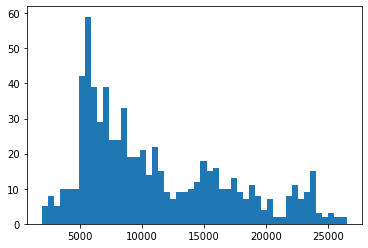

In [23]:
plt.hist(audio_lens, bins=50)

In [24]:
# this is just getting rid of syllables that are zero seconds long, which be the product of errors in segmentation
df_mask  = np.array([len(i) > 0 for i in tqdm(call_df.audio.values)])
call_df = call_df[np.array(df_mask)]

  0%|          | 0/697 [00:00<?, ?it/s]

### Normalize the audio
- you can skip this step if you don't want to normalize the audio

In [25]:
import librosa

In [26]:
call_df['audio'] = [librosa.util.normalize(i) for i in call_df.audio.values]

In [27]:
import matplotlib.pyplot as plt

  0%|          | 0/50 [00:00<?, ?it/s]

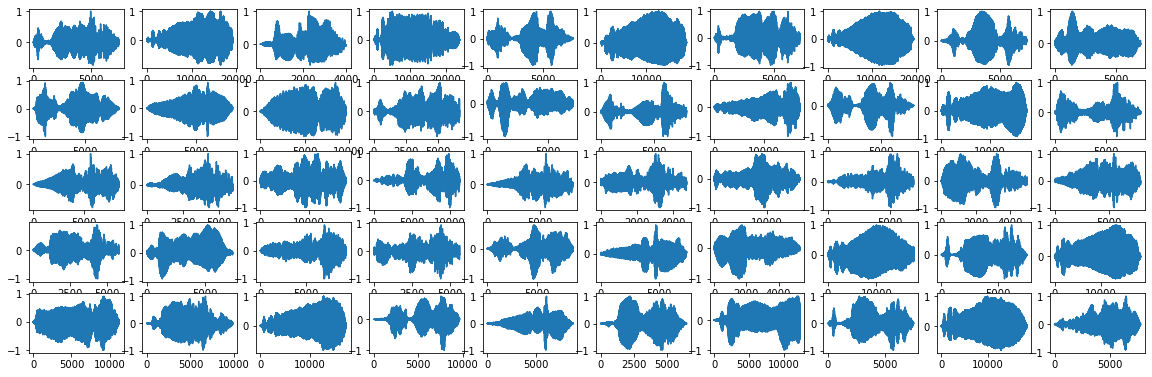

In [28]:
# plot some example audio 
nrows = 5
ncols = 10
zoom = 2
fig, axs = plt.subplots(ncols=ncols, nrows = nrows,figsize = (ncols*zoom, nrows+zoom/1.5))
for i, call in tqdm(enumerate(call_df['audio'].values), total = nrows*ncols):
    ax = axs.flatten()[i]
    ax.plot(call)
    if i == nrows*ncols -1:
        break

## Create Spectrograms

In [29]:
from avgn.visualization.spectrogram import draw_spec_set
from avgn.signalprocessing.create_spectrogram_dataset import make_spec, mask_spec, log_resize_spec, pad_spectrogram

In [30]:
calls_wav = call_df.audio.values
calls_rate = call_df.rate.values

In [31]:
with Parallel(n_jobs=n_jobs, verbose=verbosity) as parallel:
    # create spectrograms
    calls_spec = parallel(
        delayed(make_spec)(
            call,
            rate,
            hparams=dataset.hparams,
            mel_matrix=dataset.mel_matrix,
            use_mel=True,
            use_tensorflow=False,
        )
        for call, rate in tqdm(
            zip(calls_wav, calls_rate),
            total=len(call_df),
            desc="getting call spectrograms",
            leave=False,
        )
    )

getting call spectrograms:   0%|          | 0/697 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Batch computation too fast (0.0178s.) Setting batch_size=2.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Batch computation too fast (0.0506s.) Setting batch_size=4.
[Parallel(n_jobs=-1)]: Done  28 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  50 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  72 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Batch computation too fast (0.0673s.) Setting batch_size=8.
[Parallel(n_jobs=-1)]: Done 124 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Batch computation too fast (0.1107s.) Setting batch_size=16.
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done 304 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-1)]: Done 413 

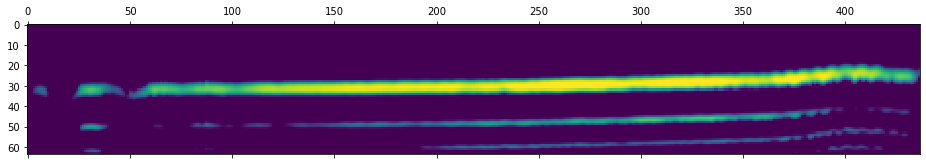

In [32]:
# plot an example call
plt.matshow(calls_spec[1])

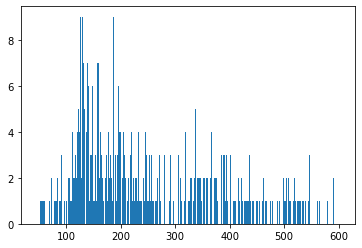

In [33]:
call_lens = [np.shape(i)[1] for i in calls_spec]

np.max(call_lens)

plt.hist(call_lens, bins=500);

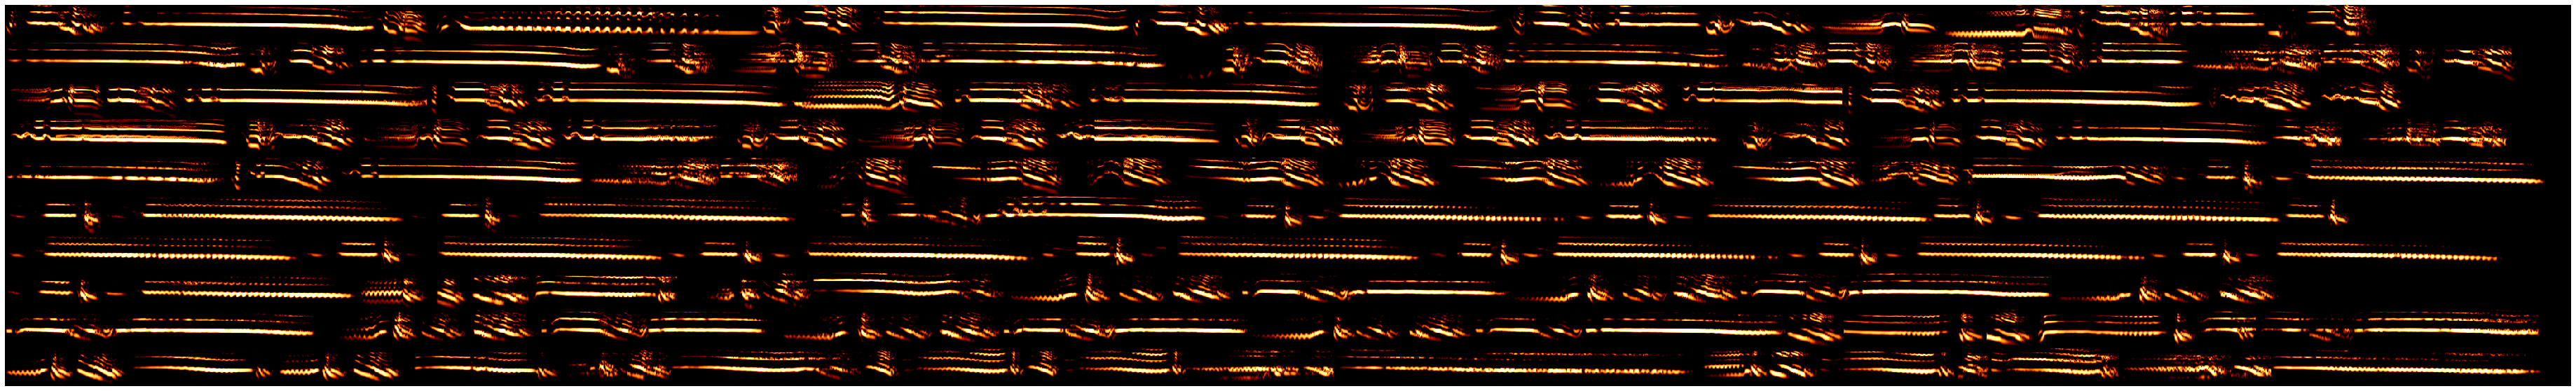

In [34]:
# lets take a look at these spectrograms
draw_spec_set(calls_spec, zoom=1, maxrows=10, colsize=25)

In [35]:
np.shape(calls_spec[0])

(64, 168)

### Rescale spectrogram
- using log scaling

In [36]:
# hyperparameter, where larger = higher dimensional spectrogram
log_scaling_factor = 10

In [37]:
import tensorflow as tf

In [38]:
with Parallel(n_jobs=n_jobs, verbose=verbosity) as parallel:
    calls_spec_log = parallel(
        delayed(log_resize_spec)(spec, scaling_factor=log_scaling_factor)
        for spec in tqdm(calls_spec, desc="scaling spectrograms", leave=False)
    )

scaling spectrograms:   0%|          | 0/697 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Batch computation too fast (0.0080s.) Setting batch_size=2.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Batch computation too fast (0.0245s.) Setting batch_size=4.
[Parallel(n_jobs=-1)]: Done  28 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  50 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  72 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Batch computation too fast (0.0219s.) Setting batch_size=8.
[Parallel(n_jobs=-1)]: Done 124 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Batch computation too fast (0.0294s.) Setting batch_size=16.
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 304 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Batch com

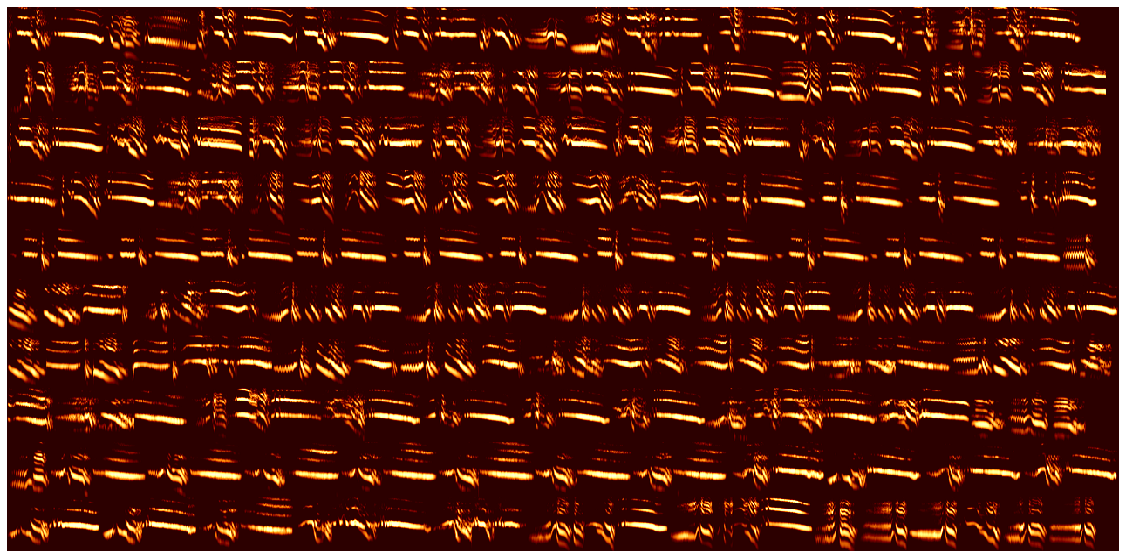

In [39]:
draw_spec_set(calls_spec_log, zoom=1, maxrows=10, colsize=25)

In [40]:
np.shape(calls_spec_log[0])

(64, 51)

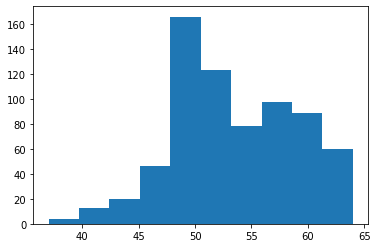

In [41]:
call_lens = [np.shape(i)[1] for i in calls_spec_log]
plt.hist(call_lens);

## Zero Padding Spectrograms

In [42]:
call_lens = [np.shape(i)[1] for i in calls_spec_log]
pad_length = np.max(call_lens)

In [44]:
with Parallel(n_jobs=n_jobs, verbose=verbosity) as parallel:

    calls_spec_logpad = parallel(
        delayed(pad_spectrogram)(spec, pad_length)
        for spec in tqdm(
            calls_spec_log, desc="padding spectrograms", leave=False
        )
    )

padding spectrograms:   0%|          | 0/697 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Batch computation too fast (0.0075s.) Setting batch_size=2.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Batch computation too fast (0.0257s.) Setting batch_size=4.
[Parallel(n_jobs=-1)]: Done  28 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  50 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  72 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Batch computation too fast (0.0220s.) Setting batch_size=8.
[Parallel(n_jobs=-1)]: Done 124 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Batch computation too fast (0.0253s.) Setting batch_size=16.
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 304 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Batch com

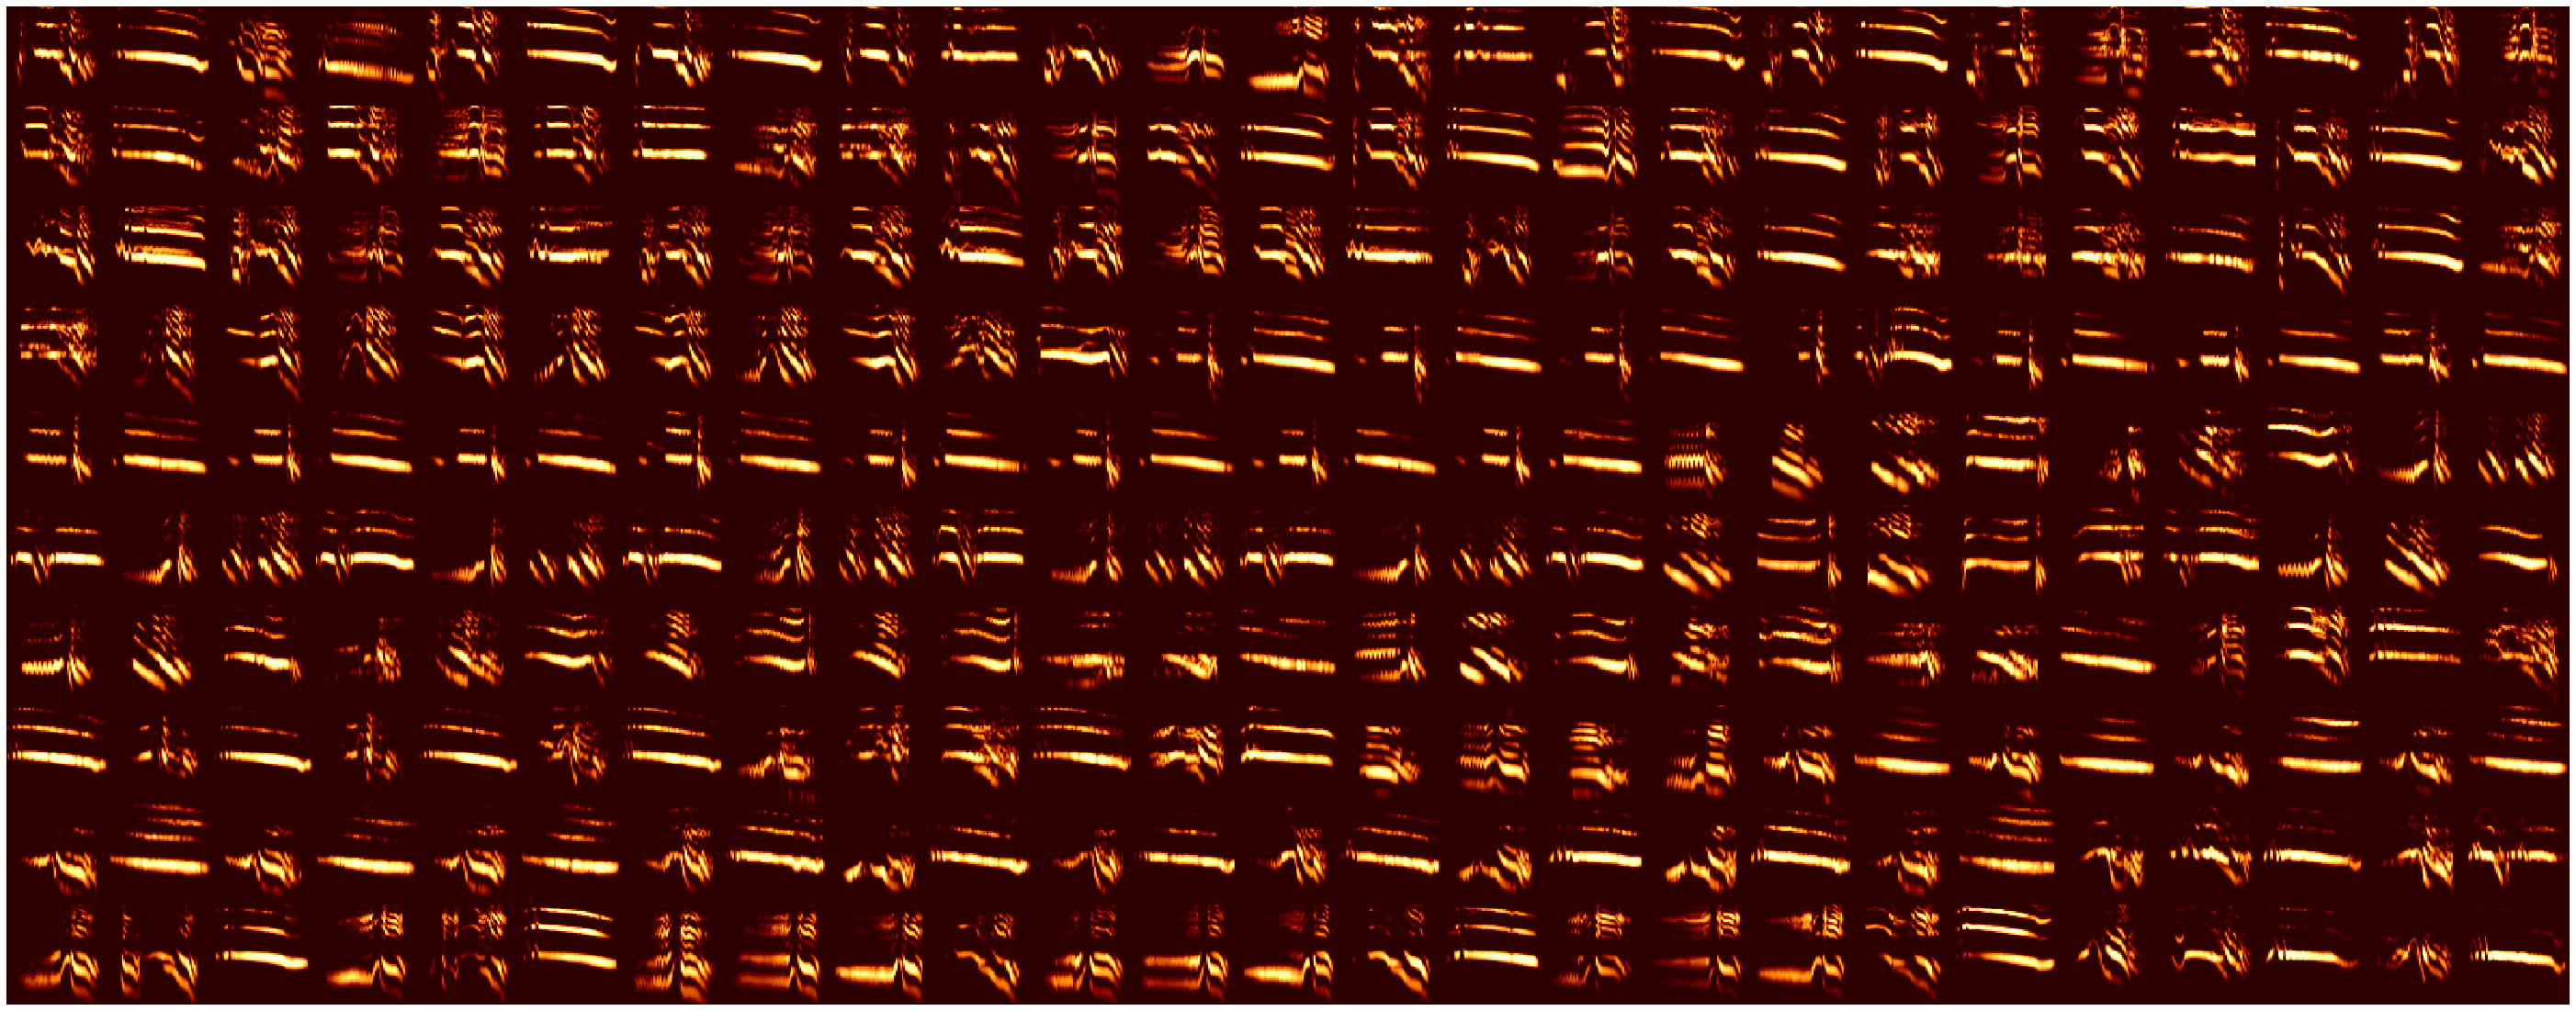

In [47]:
draw_spec_set(calls_spec_logpad, zoom=2, maxrows=10, colsize=25)

In [48]:
np.shape(calls_spec_logpad)

(697, 64, 64)

## Put info into dataframes

In [49]:
call_df['specs'] = calls_spec_logpad

In [50]:
call_df[:3]

,start_time,end_time,ID,labels,start_times,end_times,call_unique_num,call_pos_combi,combi_label,combi_unique_num,...,indvi,filename,group,location,sex,wav_loc,key,audio,rate,specs
0,0.753604,0.921160,0,DSSHDS,0.753604,0.921160,0,0,DSSHDS SHSHLH,0,...,0,BWY MGGY Call Combo 1 290719 PM,BWYa,CRAWLEY,F,C:/Users/slwal/anaconda3/envs/PY36/avgn_paper-...,BWY MGGY Call Combo 1 290719 PM,"[0.0022912608, 0.0026525275, 0.0028976116, 0.0...",44100,"[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,..."
1,0.932017,1.367130,1,SHSHLH,0.932017,1.367130,1,1,DSSHDS SHSHLH,0,...,0,BWY MGGY Call Combo 1 290719 PM,BWYa,CRAWLEY,F,C:/Users/slwal/anaconda3/envs/PY36/avgn_paper-...,BWY MGGY Call Combo 1 290719 PM,"[0.011838197, 0.010573517, 0.00891353, 0.00765...",44100,"[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,..."
0,1.218085,1.308841,2,DS,1.218085,1.308841,2,0,DS USC,1,...,0,BWY MGGY Call Combo 1 300719 AM,BWYa,CRAWLEY,F,C:/Users/slwal/anaconda3/envs/PY36/avgn_paper-...,BWY MGGY Call Combo 1 300719 AM,"[-0.0016146533, -0.00053380395, 0.00075247855,...",44100,"[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,..."


### save dataset

In [51]:
from avgn.utils.paths import DATA_DIR, ensure_dir

In [52]:
save_loc = DATA_DIR / DATASET_ID / DT_ID /  'walsh_magpie_call_gitrepos.pickle'
ensure_dir(save_loc.as_posix())
# we'll save without the audio (optional)
call_df.drop('audio', 1).to_pickle(save_loc)